In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fft2, ifft2, fftn, ifftn
from turb.lesgo_utils import lesgo_data, read_array_from_file, write_array_to_file
from pyutils.cartesian import meshgrid, coords_xyz
from matplotlib import colors, cm
# from pynfft.nfft import NFFT

In [16]:
# Format 
marker_size = 15
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
font_size = 16
plt.rcParams['font.size'] = font_size
plt.rcParams['text.usetex'] = True


default_figargs={
    "figsize":  (5, 4),
    "dpi": 150,
}

default_contourargs={
    "cmap": cm.pink_r,
}

In [17]:
dims = [128, 128, 64]
domain = [2*np.pi, np.pi, 1]
coords = coords_xyz(domain, dims, center=True, stretch=True)
fname = "/Users/user/Downloads/adjoint.001.00030000"
adjoint = read_array_from_file(fname, dims, dtype=np.float64)

source_locs = np.array([[0.6*np.pi],
                        [0.5*np.pi],
                        [0.5],
                        ])
ldata = lesgo_data(domain, dims, ".", ntheta=3)
xc, yc, zc = ldata.coords
xx, yy, zz = np.meshgrid(xc, yc, zc, indexing='ij')


In [18]:
from scipy.ndimage import gaussian_filter
# f = np.random.random(100)
result = gaussian_filter(adjoint, sigma=5)

# Convolution with stretched coordinate
In the channel flow simulation, we use the stretched coordinate in z direction,

<!-- z_range[1]*(1+(np.tanh(str_factor*(z_coords/z_range[1]-1))/np.tanh(str_factor))) -->
$$
\zeta = L_z \left(1+  \frac{\tanh{ \left(\left(\frac{ z}{L_z}-1\right)\alpha\right)} }{ \tanh{\alpha}}\right).
$$

and the difference is 

$$
\mathrm{d}\zeta = \frac{\mathrm{d}\zeta}{\mathrm{d}z} \mathrm{d}z.
$$


Fourier transform of function is

$$
f(z) = \frac{1}{\sqrt{2\pi}}\int \hat{f}(k) e^{\mathrm{i} kz} \mathrm{d} k.
$$

In [19]:
dx = zc[1:] - zc[:-1]
dx = np.concatenate((dx, np.array([1 - zc[-1] + zc[0]])))

In [20]:
from nfft import nfft, nfft_adjoint
x = coords[2]
sigma = 1e-1

f = adjoint*1
f_ij = fft(fft(f*ldata.volume, axis=0), axis=1)
f = f_ij[0, 0, :]

# Shift the kernel center to the edge so that the convolution is 
# the correct gaussian filer
N = len(f)
k = np.arange(N) / N 
g = np.exp(-( (x-0.5)/sigma )**2/2)

# FFT
# gshift = np.roll(g, -g.argmax())
# f_hat = fft(f)
# g_hat = fft(gshift)

# NFFT
f_hat = nfft_adjoint(x-0.5, f * dx, len(f))
g_hat = nfft_adjoint(x-0.5, g * dx, len(g))
# f_convolv_g = ifft(f_hat * g_hat)
f_convolv_g = nfft(x-0.5, f_hat * g_hat * N)


direct_convol = np.zeros(f.shape)
for i, u in enumerate(f):
    direct_convol[i] = np.sum(f* np.exp(-( (x-x[i])/sigma )**2/2))

# f_convolv_g = ifft(f_hat * g_hat)

/var/folders/k8/qt94yf_n5xgbshl47l1m1drr0000gn/T/ipykernel_15123/2615779835.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  direct_convol[i] = np.sum(f* np.exp(-( (x-x[i])/sigma )**2/2))


In [21]:
# Linearize
lx = np.linspace(0, 1, N)
fxx = np.interp(lx, x, f)
gxx = np.exp(-( (lx-0.5)/sigma )**2/2)
gshift = np.roll(gxx, -gxx.argmax())

fxx_hat = fft(fxx)
gxx_hat = fft(gshift)

fgxx = ifft(fxx_hat * gxx_hat)

In [22]:
# Corr
weight_corr = np.exp(- (  zc[np.newaxis, :]- zc[:, np.newaxis])**2 /2/ sigma**2)
fg_corr = f @ weight_corr

/opt/anaconda3/envs/turb/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/turb/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, '$z$')

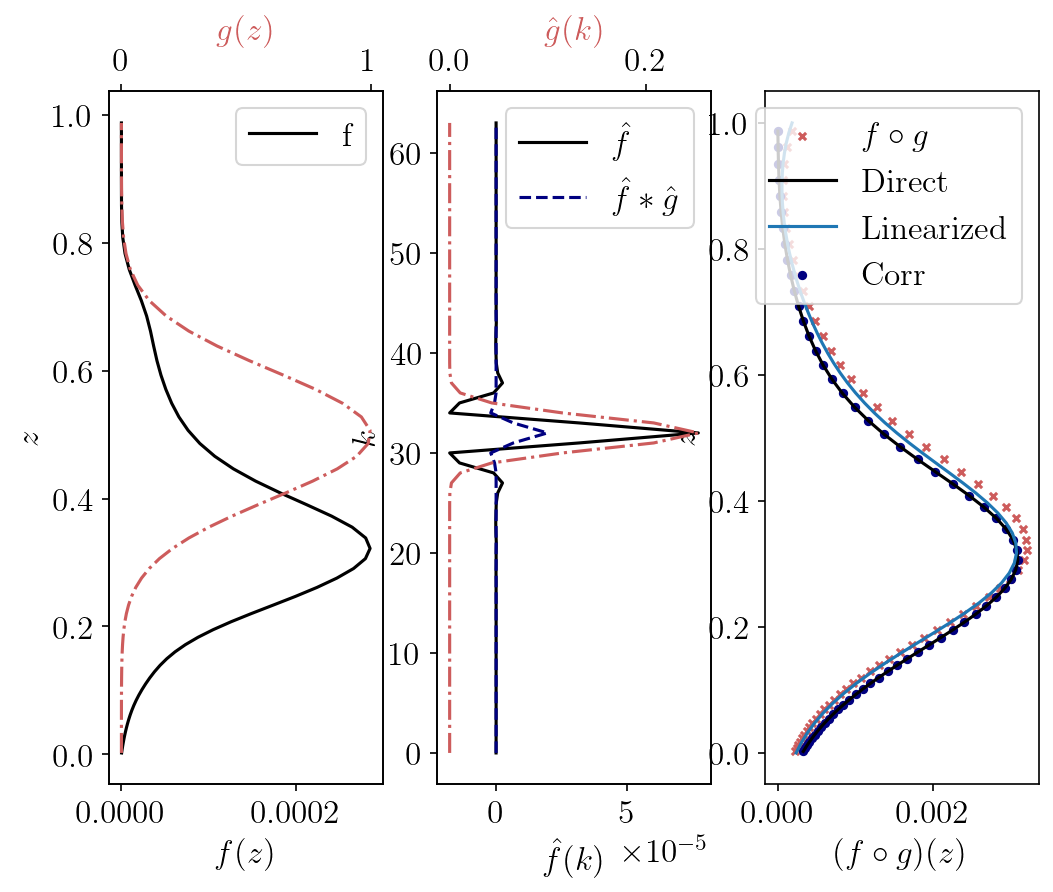

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(8, 6), dpi=150)
ax = ax.flatten()
ax[0].plot(f, x, label='f', linestyle='-', color='black')
ax0 = ax[0].twiny()
ax0.plot(g, x, label='g', linestyle='-.', color='indianred')
ax[0].legend(frameon=True, loc=1)
ax[0].set_xlabel('$f(z)$')
ax[0].set_ylabel('$z$')
ax0.set_xlabel('$g(z)$', color='indianred')

ax[1].plot(f_hat, np.arange(len(f_hat)), label='$\hat{f}$', linestyle='-', color='black')
ax1 = ax[1].twiny()
ax1.plot(g_hat, np.arange(len(g_hat)), label='$\hat{g}$', linestyle='-.', color='indianred')
ax[1].plot(f_hat * g_hat, np.arange(len(g_hat)), label='$\hat{f}*\hat{g}$', linestyle='--', color='navy')
ax[1].legend(frameon=True, loc=1)
ax[1].set_xlabel('$\hat{f}(k)$')
ax[1].set_ylabel('$k$')
ax1.set_xlabel('$\hat{g}(k)$', color='indianred')

ax[2].scatter(f_convolv_g, x, s=12, label='$f \circ g$', marker='x', color='indianred')
# ax2 = ax[2].twiny()
ax[2].plot(direct_convol, x, label='Direct', linestyle='-', color='black')
ax[2].plot(fgxx, lx, label='Linearized')
ax[2].scatter(fg_corr, x, s=12, label='Corr', color="navy", marker='o')
ax[2].legend(frameon=True, loc=1)
ax[2].set_xlabel('$(f\circ g)(z)$')
ax[2].set_ylabel('$z$')

# 3D convolution with stretched coordinate

In [24]:
g = np.exp(- ((xc[:, np.newaxis] - domain[0]/2)**2 + (yc[np.newaxis,:] - domain[1]/2)**2) /1e-2/2)
g = np.roll(g, -g.argmax())
g_ij = fft(fft(g, axis=0), axis=1)

In [25]:
# FFT Convolution
f = adjoint*1
f_w = f * ldata.volume
f_ij = fft(fft(f_w, axis=0), axis=1)

f_convolv_g = ifft(ifft(f_ij * g_ij[:, :, np.newaxis], axis=0), axis=1) @ weight_corr


Text(0, 0.5, '$y$')

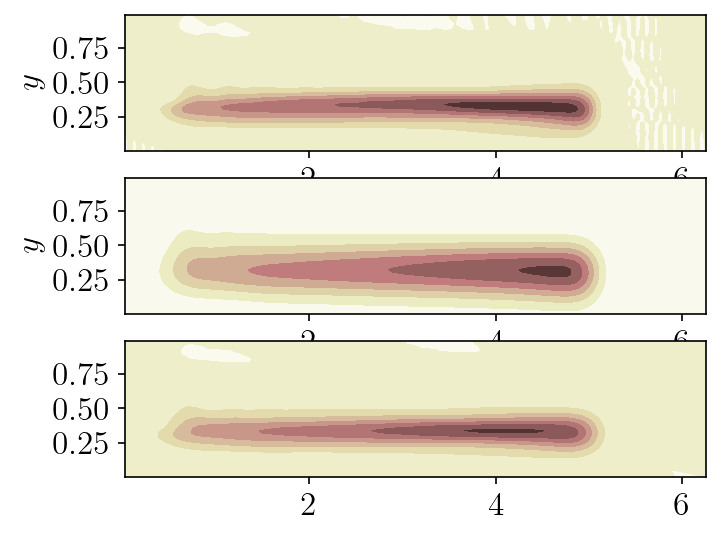

In [26]:
fig, axes = plt.subplots(3, 1, **default_figargs)
axes[0].contourf(coords[0], coords[2], f[:, 64, :].T, **default_contourargs)
axes[1].contourf(coords[0], coords[2], f_convolv_g[:, 64, :].T, **default_contourargs)
axes[2].contourf(coords[0], coords[2], (ifft(ifft(f_ij * g_ij[:, :, np.newaxis], axis=0), axis=1))[:, 64, :].T, **default_contourargs)

axes[1].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[1].set_ylabel('$y$')

In [27]:
source_index = []
for ind, ax in enumerate([xc, yc, zc]):
    source_index.append(np.unravel_index(np.abs(ax - source_locs[ind, 0]).argmin(), dims[ind])[0])
print(source_index)

source_weight = np.exp(-( (xx-source_locs[0, 0])**2 + (yy-source_locs[1, 0])**2 + (zz-source_locs[2, 0])**2 )/1e-2/2)
adjoint = read_array_from_file(fname, dims)
average_adjoint = np.sum(adjoint * source_weight * ldata.volume)

[38, 63, 43]


In [28]:
print("Direct Convolution")
print(average_adjoint)
print("FFT convolution")
print(np.real(f_convolv_g[38, 63, 43]))
print("Gaussian Filter")
print(result[38, 63, 43])


Direct Convolution
3.832723952374822e-05
FFT convolution
3.7991073109026634e-05
Gaussian Filter
0.002229963775979566
